# Rt per provincia

Rt di COVID-19 stimato per le province italiane.

> Max Pierini & [NOTIZIÆ Telegram Channel](https://t.me/notiziae)

***

**NB**: gli $R_t$ stimati da EpiDataItalia possono differire da quelli dell'Istituto Superiore di Sanità (ISS) perchè
-  i dati utilizzati da ISS provengono dal flusso di Sorveglianza Integrata (per dettagli consultare [EpiCentro](https://www.epicentro.iss.it/coronavirus/sars-cov-2-dashboard)), in continuo aggiornamento e consolidamento, mentre EpiDataItalia usa i dati comunicati giornalmente dal Ministero della Salute
-  ISS usa metodo *EpiEstim* ([A new framework and software to estimate time-varying reproduction numbers during epidemics, Cori-Ferguson-Fraser 2013](https://doi.org/10.1093/aje/kwt133)) sui soli **casi sintomatici** trasmessi localmente (stimati con contact-tracing) e decurtando i casi verosimilmente importati mentre EpiDataItalia ha scelto di stimare sui casi totali (sintomatici e non-sintomatici) per assenza di sufficienti evidenze che i soggetti asintomatici non siano in grado di trasmettere l'infezione
- per riprodurre la stima di $R_t$ di ISS è possibile utilizzare i dati e lo script in linguaggio `R` forniti da EpiCentro a [questo indirizzo](https://www.epicentro.iss.it/coronavirus/sars-cov-2-dashboard)

> Per chiedere al Governo l'accesso pubblico a tutti i dati grezzi disaggregati di COVID-19 in Italia consigliamo l'adesione alla **[Petizione DatiBeneComune](https://datibenecomune.it)**.

***

Modelli utilizzati: JARE, vedi [Stime Rt](https://www.epidata.it/Italia/Rt_stime.html) per dettagli
***

In [1]:
import datetime as dt
import json

import numpy as np
import pandas as pd
import scipy.stats as sps
import pyjags
import arviz as az
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

sns.set()
sns.set_palette('colorblind')

In [2]:
start = dt.datetime.now()

In [3]:
SI_sh_ISS = 1.87
SI_ra_ISS = 0.28

In [4]:
def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

In [5]:
def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        lambda_sum = np.sum(_lambda[t_start[t]:t_end[t]+1])
        if t_end[t] > final_mean_si and incid_sum > 50:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + lambda_sum)
        else:
            a_posterior[t] = .01
            b_posterior[t] = 1
    return a_posterior, b_posterior, lambda_sum

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99, samples=1000,
                 plot_incidence=False,
                 plot_Rt=False,
                 plot_SI=False,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - CI) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    SI_mu = SI_dist.stats(moments='m')
    SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_y = SI_dist.pdf(SI_x)
    # pad SI with zeros
    SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2
    b_prior = (sd_prior ** 2) / mu_prior
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior, lambda_sum = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    last_Rt_samples = sps.gamma.rvs(
        a=a_posterior[-1], scale=b_posterior[-1], 
        size=samples
    )
    
    res_index = idx[:-window]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:    
        ax = res.plot(
            y='R', color='w', alpha=.25, lw=1, figsize=(12, 5), title=title, ylim=(0, 5)
        )

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior<1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior<1, quantile_lo_posterior, 1), 
            alpha=1, color='C2', label='lower than 1')

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior>1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior>1, quantile_lo_posterior, 1), 
            alpha=1, color='C3', label='higher than 1')

        ax.set(
            title=f'{title}: Rt estimation (EpiEstim method, window {window} days, '+\
                  f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days) '+\
                  f'C.I. {CI:.0%}',
            ylim=(0, 4),
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        ax.legend(loc='upper right')

        ax.axhline(1, color='k', ls='-')
        plt.show()
    
    return res, last_Rt_samples

In [6]:
def epidata_Rt(df, column,
               SI_sh, SI_ra,
               window=14, ignore_below=25,
               hdi_prob=.99,
               seed=42, chains=4, adapt=5, warmup=25, sample=50,
               verbose=False, plot=True, title='Italia'
              ):

    dist = sps.gamma(a=SI_sh, scale=1/SI_ra)

    size = df.index.size
    SI_x = np.linspace(0, size, size)
    SI_y = dist.pdf(SI_x)
    SI_y /= SI_y.sum()
    SI_cdf = SI_y.cumsum()
    SI_cdf_rev = SI_cdf[::-1]
    
    SI_mu = dist.mean()
    SI_sd = dist.std()
    
    wallingaString = """
    var weight_cases_for_s[T,T], prob_cases_for_s[T,T], weight_cases_norms[T,T];

    model {
        unknown_Rt ~ dnorm( 0 , 1/(0.1)^2 ) T(0,)
        prob_cases_for_s[1,1] <- 0
        
        P[1] ~ dpois( y[1] )
        Y[1] <- ifelse( P[1] > 0 , P[1] , 1.0E-32 )
        
        for ( s in 2:T ) {
            P[s] ~ dpois( y[s] )
            Y[s] <- ifelse( P[s] > 0 , P[s] , 1.0E-32 )
            
            weight_cases_for_s[s,1:(s-1)] <- Y[1:(s-1)] * SI_pdf_rev[(T-(s-1)):(T-1)]
            weight_cases_tmp[s] <- sum( weight_cases_for_s[s,1:(s-1)] )
            weight_cases_sum[s] <- ifelse( weight_cases_tmp[s] > 0 , weight_cases_tmp[s] , 1.0E-32 )
            weight_cases_norms[s,1:(s-1)] <- weight_cases_for_s[s,1:(s-1)] / weight_cases_sum[s]
            
            prob_cases_for_s[s,1:(s-1)] <- weight_cases_norms[s,1:(s-1)] * Y[s] / Y[1:(s-1)]

        }
        
        R_raw[1] <- sum( prob_cases_for_s[1:T,1] )
        R_raw[2] <- sum( prob_cases_for_s[3:T,2] )
        for ( s in 3:(T-1) ) {
            min_idx[s] <- ifelse( s > (window+1) , (s-window) , 1 )
            window_Y[s] <- sum( Y[min_idx[s]:(s-1)] )
            R_raw[s] <- ifelse(
                window_Y[s] > ignore_below ,
                sum( prob_cases_for_s[(s+1):T,s] ) ,
                unknown_Rt
            )
        }

        R[1:(T-1)] <- R_raw[1:(T-1)] / SI_cdf_rev[1:(T-1)]
    }
    """
    
    denominators = df[column].values
    denominators[denominators<=0] = 1e-3
    
    wallinga_model_data = {
        'y': df[column].values,
        'T': size,
        #'den': denominators,
        'SI_pdf_rev': SI_y[::-1],
        'SI_cdf_rev': SI_cdf_rev,
        'window': window,
        'ignore_below': ignore_below
    }

    wallinga_jags_model = pyjags.Model(
        code=wallingaString, 
        data=wallinga_model_data,
        chains=chains, 
        adapt=adapt,
        progress_bar=verbose,
        init={'.RNG.name': "base::Wichmann-Hill", ".RNG.seed": seed}
    )

    wallinga_jags_posteriors = wallinga_jags_model.sample(
        warmup + sample, vars=['R']
    )
    
    R_data = az.from_pyjags(wallinga_jags_posteriors,
        warmup_iterations=warmup, save_warmup=False)

    R = az.summary(
        R_data, hdi_prob=hdi_prob,
        var_names='R', kind='stats')
    R.index = df.index[:-1]
    
    if plot:
        fig, ax = plt.subplots(figsize=(12, 4))
        R.plot(
            y='mean', color='k', lw=1, ax=ax,
            legend=False
        )
        
        ax.fill_between(
            R.index, 
            R['hdi_0.5%'], R['hdi_99.5%'],
            alpha=.25, color='k',
            interpolate=True
        )
        _ = """
        ax.fill_between(
            R.index, 
            np.where(R['hdi_99.5%']<=1, R['hdi_99.5%'], 1), 
            np.where(R['hdi_0.5%']<=1, R['hdi_0.5%'], 1), 
            alpha=1, color='C2', label='lower than 1',
            interpolate=True
        )

        ax.fill_between(
            R.index, 
            np.where(R['hdi_99.5%']>1, R['hdi_99.5%'], 1), 
            np.where(R['hdi_0.5%']>1, R['hdi_0.5%'], 1), 
            alpha=1, color='C3', label='higher than 1',
            interpolate=True
        )"""

        ax.set(
            title=f'{title}: Rt estimation (Wallinga-Teunis-EpiData.it, '+\
                  f'SI  $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$ days) '+\
                  f'C.I. {hdi_prob:.0%}',
            ylim=(0, 4),
            #xlim=xlim,
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        #ax.legend(False)

        ax.axhline(1, color='r', ls='--', lw=1)
        plt.show()

    return R

In [7]:
def pierini_Rt(df, column, ignore=5,
               SI_sh=None, SI_ra=None, 
               conf_int=.99, smooth=7,
               #resample='last-day-of-week',
               func=np.mean, samples=100,
               plot_latest_Rt=False,
               plot=False, title='', ylim=(0, 5)):
    
    """
    Estimate Istantaneous Reproduction Number Rt with
    given observed incidence and serial interval ditribution
    parameters (shape and rate of Gamma distribution).
    Results are resampled given the chosen method
    (default: by week, starting from last day) and function
    (default: mean).
    
    Args:
    ----------------------------------------------------------------
    df       : (dataframe) : dataframe of observed incidence [1]
    column   : (string)    : column of incidence in dataframe
    SI_sh    : (float)     : serial interval distribution shape [2]
    SI_ra    : (float)     : serial interval distribution rate [2]
    conf_int : (float)     : wanted confidence interval
    resample : (string)    : resample string [3]
    func     : (function)  : resample function [4]
    plot     : (boolean)   : plot results or not
    
    Returns:
    ----------------------------------------------------------------
    A pandas dataframe with estimated Rt and confidence intervals.
    
    Notes:
    ----------------------------------------------------------------
    [1] the dataframe should contain at least a column with observed
        incidence and index should refer to observations datetime
    [2] if no shape/rate are defined, a default one will be assigned
    [3] see pandas documentation for resample offset strings
    [4] default is np.mean
    """

    _lo = (1 - conf_int) / 2 * 100
    _hi = 100 - _lo
    
    df = df.copy(deep=True)
    T = df.index.size
    
    Rt0 = sps.halfnorm(0, 0.1).rvs(samples)
    
    less_than_zero = df[column]<0
    if less_than_zero.sum():
        print('Warning: negative values in incidence. Adjusting...')
        df.loc[less_than_zero, column] = 0

    if SI_sh is None or SI_ra is None:
        print('Warning: no serial interval given.')
        print('Assigning default one...')
        SI_sh = 1.87
        SI_ra = 0.28
    
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x = np.arange(1, T+1, 1)
    SI_y = SI_dist.pdf(SI_x)

    pois_vars = np.zeros(shape=(T, samples))
    for t in range(T):
        pois_var = sps.poisson.rvs(df[column].values[t], size=samples)
        pois_vars[t,:] = pois_var

    Rt = np.zeros(shape=(T, samples))
    for t in range(T):
        if t < 1:
            continue
        if np.any(pois_vars[t] < ignore):
            Rt[t,:] = Rt0
            continue
        last = pois_vars[t]
        old = (pois_vars[:t] * SI_y[:t][::-1][:,None]).sum(axis=0)
        if np.any(old < ignore):
            Rt[t,:] = Rt0
            continue

        R_rvs = last / old
        Rt[t,:] = R_rvs
        
    Rt[0,:] = Rt[1:8].mean(axis=0)
    R = pd.DataFrame(columns=['R', 'sd', 'lo', 'hi'])
    R['R'] = np.median(Rt, axis=1)
    R['sd'] = np.std(Rt, axis=1)
    R['lo'], R['hi'] = np.percentile(Rt, [_lo, _hi], axis=1)
    R.index = df.index
    
    R_smoothed = R.rolling(smooth).mean()
    R_smoothed = R_smoothed[(smooth-1):]
    R_smo_len = R_smoothed.index.size
    idx_min = smooth // 2
    idx_max = R_smo_len + idx_min
    R_smoothed.index = R.index[idx_min:idx_max]
    
    latest_sh = R_smoothed.R[-1]**2 / R_smoothed.sd[-1]**2
    latest_ra = R_smoothed.R[-1] / R_smoothed.sd[-1]**2
    latest_Rd = sps.gamma(a=latest_sh, scale=1/latest_ra)
    latest_Rs = latest_Rd.rvs(size=10000)
    latest_Rx = np.linspace(latest_Rd.ppf(_lo/100), latest_Rd.ppf(_hi/100), 100)
    latest_Ry = latest_Rd.pdf(latest_Rx)
    latest_Rm = latest_Rd.mean()
    if latest_Rm > 1:
        p_val = latest_Rd.cdf(1)
    else:
        p_val = 1 - latest_Rd.cdf(1)
    
    if plot:
        ax = R_smoothed.plot(
            figsize=(12, 5), y='R', color='k',
            lw=1,
        )
        ax.fill_between(
            R_smoothed.index,
            R_smoothed.lo, R_smoothed.hi,
            color='k', alpha=.25,
            label=f'C.I. {conf_int:.0%}'
        )
        ax.axhline(1, color='r', ls='--')
        ax.legend()
        ax.set(
            title=f'{title} Rt estimation (Method: JARE-Pierini 2020)',
            ylabel='R(t)', xlabel='date',
            ylim=ylim
        )
        plt.show()
        
    if plot_latest_Rt:
        ax = az.plot_posterior(
            latest_Rs, ref_val=1,
            figsize=(8, 3),
            round_to=5,
            hdi_prob=conf_int,
            textsize=15
        )
        ax.text(
            .05, 1.1,
            f'$p$-val = {p_val:.3f}',
            fontsize=10, color='k',
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(.2, .2, .2),
                   fc=(.9, .9, .9, .5),
                   ),
            transform=ax.transAxes
        )
        ax.set(
            title=f'{title} Latest Rt {R_smoothed.index[-1].date()} (Method: JARE-Pierini 2020)'
        )
        plt.show()
    
    return R_smoothed, latest_Rs

# Province

In [8]:
def covid_province():
    df = pd.read_csv(
        "https://github.com/pcm-dpc/COVID-19/raw/master/dati-province/dpc-covid19-ita-province.csv",
        parse_dates=['data']
    ).sort_values(by='data')
    df['data'] = df.data.dt.normalize()
    return df

In [9]:
pro = covid_province()

In [10]:
pro.loc[
    (pro.denominazione_provincia.str.contains('aggiornamento')) |
    (pro.denominazione_provincia.str.contains('Fuori'))
    , 'denominazione_provincia'] = np.nan

In [11]:
pro.dropna(subset=['denominazione_provincia'], inplace=True)

In [12]:
def last_Rt_simulation(incidence, 
                       SI_sh, SI_ra, 
                       ci=.95, samples=1000):
    """
    ***********************************
    * Max Pierini - EpiData.it - 2020 *
    ***********************************
    
    Calculate the last Rt given observed incidence
    and serial interval Gamma distribuion parameters
    with confidence intervals from Poisson
    distribution of observed incidence.
    
    Args:
        incidence (numpy array) <- array of observed incidence

        SI_sh     (float)       <- shape of serial interval 
                                   gamma distribution
        SI_ra     (float)       <- rate of serial interval
                                   gamma distribution
        ci        (float)       <- confidence interval for Rt
                                   (default: .95)
        samples   (integer)     <- samples of Poisson distribution
                                   (default: 1000)
                                   
    Returns:
        A tuple of (mean, lower, upper) Rt
        of last day and generated samples.
        
    Notes:
        Based on Wallinga-Teunis Rt esimation.
        See https://doi.org/10.1093/aje/kwh255
    """

    # define lower and upper conf. int.
    lo = (1 - ci) / 2 * 100
    hi = 100 - lo
    
    undefined_R = sps.halfnorm(loc=0, scale=0.1)
    _R_mu = undefined_R.mean()
    _R_lo, _R_hi = undefined_R.ppf([lo, hi])
    _last_R_simu = undefined_R.rvs(size=samples)
    
    if incidence[-1] <= 1 or incidence[-2] <= 1:
        #print('1')
        return _R_mu, _R_lo, _R_hi, _last_R_simu
    
    # get the size of observations
    size = incidence.size
    
    # define the discretized serial interval
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x = np.linspace(0, size, size)
    SI_y = SI_dist.pdf(SI_x)
    SI_y /= SI_y.sum()
    
    # distribute observed incidence
    # till second-to-last day
    pois_old = np.random.poisson(
        incidence[:-1],
        size=(samples, size-1)
    )

    # ponderate observation on serial interval
    weights = pois_old * SI_y[1:][::-1]

    # normalize calculated weights
    weights_sum = np.sum(weights, axis=1)
    weights_norm = weights[:,-1] / weights_sum

    # Poisson distribution of last two days
    pois_Y1 = sps.poisson.rvs(incidence[-1], size=samples)
    pois_Y2 = sps.poisson.rvs(incidence[-2], size=samples)
    # avoid divisions by zero
    pois_Y2 = np.where(pois_Y2==0, np.nan, pois_Y2)
    pois_Y2 = pois_Y2[~(np.isnan(pois_Y2))]
    sample_size = pois_Y2.size

    # Wallinga-Teunis definition of Rt
    # and Cauchemez adjustment for real time
    last_R_simu = (weights_norm[:sample_size] * pois_Y1[:sample_size] / pois_Y2) / SI_y.cumsum()[1]

    # Mean and confidence interval of Rt
    try:
        R_mu = np.mean(last_R_simu)
        R_lo, R_hi = np.percentile(last_R_simu, [lo, hi])
    except:
        #print('err')
        return _R_mu, _R_lo, _R_hi, _last_R_simu
    
    return R_mu, R_lo, R_hi, last_R_simu

In [13]:
def get_serial_interval(sh, ra, size):
    dist = sps.gamma(a=sh, scale=1/ra)
    x = np.arange(0, size, 1)
    y = dist.pdf(x)
    y /= y.sum()
    return y


def wallinga_teunis_Rt(df,
                       SI_sh, SI_ra,
                       CI=.99,
                       n_t0=None,
                       imported=None,
                       nsim=10000,
                       correct=True,
                       ignore_below=10,
                       plot=False, ylim=(0, 4),
                       title='RESULTS'):
    
    epid = df.values
    start = 0
# --------->    
    if epid[0] == 0:
        start = (epid>0).nonzero()[0][0] + 1
# --------->    
    epid = epid[start:]
    
    # define the confidence interval
    q1 = (1 - CI) / 2
    q2 = CI - q1
    
    #Beginning of estimation 
    Tmax = epid.size
    
    #At the same time, multiple simulation to estimate quantiles for R(t) values.
    #At each time unit 's', we count how many offspring come from each of [1:s] time unit 
    multinom_simu = np.zeros(shape=(Tmax, Tmax, nsim))
    
    #Unknown initial n0 is set to first recorded value
    if n_t0 is None:
        n_t0 = epid[0]
    
# --------->
    # TBD imported
# --------->
    
    #Matrix to store probabilities
    #P[i,j] the mean number of offspring at time j caused by infected at time i
    #p[i,j] is proba that a case i infected case j
    PI = np.zeros(shape=(Tmax, Tmax))
    pi = np.zeros(shape=(Tmax, Tmax))
    
    #Pad GI with 0s to allow for matrix multiplication
    #GT_to_0 = Tmax - GT.size
    #GI = np.concatenate((GT, np.repeat(0, GT_to_0)))
    #GI /= np.sum(GI)
    GI = get_serial_interval(SI_sh, SI_ra, Tmax)
    assert GI.size == Tmax
    
    #If autonomous cases were incident on day s, we have to find how previous cases may have contributed to them
    for s in range(Tmax):

        #Skip 1st
        if s < 1:
            continue

        if epid[s] > ignore_below:

            #weights for index case detected on day s
            c = np.concatenate((np.repeat(0, s), [1]))
            assert c.size == epid[:s+1].size
            weight_cases_for_s = (epid[:s+1] - c) * GI[:s+1][::-1]

            #normalization
            weight_cases_for_s[weight_cases_for_s<=0] = 1e-64
            weight_cases_for_s /= weight_cases_for_s.sum()
            weight_cases_for_s[np.isnan(weight_cases_for_s)] = 1e-64

            #Likelihood of a infected at time s to have been caused by parent in [1:s]
            #prob.cases.for.s[i] is the expected number of offspring on day s from one individual on day i
            _den = (epid[:s+1] - c)
            _den[_den <= 0] =1e-64
            prob_cases_for_s = weight_cases_for_s * epid[s] / _den
            prob_cases_for_s[:-1][epid[:s]==0] = 0

            #Should not be required, but just in case
            #only 1 icident case on day s: can't be its own infector
            if epid[s] == 1:
                prob_cases_for_s[s] = 0

            #PI will store the average number of offspring coming from each time unit :
            #PI[i,j] is the mean number of offspring at time j caused by infected at time i
            PI[:s+1,s] = prob_cases_for_s

            #Probabilities (empirical) are obtained obtained from weight_cases_for_s
            pi[:s+1,s] = weight_cases_for_s

            #We generate a high number of simulations with the computed probabilities
            #to find out how many infection result from each time unit.
            #multinom.sim list is updated from previous value, so we don't have to sum all lists at the end
            multinom_matrix = np.random.multinomial(
                epid[s],
                pi[:s+1,s],
                size=nsim,
            ).transpose()
            multinom_simu[s,:s+1,:] = multinom_simu[s-1,:s+1,:] + multinom_matrix

        else:

            PI[:s+1,s] = 0
            pi[:s+1,s] = 0
            multinom_simu[s,:s+1,:] = multinom_simu[s-1,:s+1,:]

    #We now have enough data to compute R (from infection network PI)
    #along with its 5% and 95% quantiles (from multiple simulations and pi)
    R_WT = PI.sum(axis=1)    # Wallinga and Teunis definition
    _den = np.cumsum(GI)[::-1]
    _den[_den <= 0] = 1e-64
    R_corrected = R_WT / _den   # Corrected for real time
    if np.isnan(R_corrected[Tmax-1]):
        R_corrected[Tmax-1] = 0
        
    #Simulated incidence at each time unit is the sum of all cases,
    #stored in the last element of multinom.sim list
    total_infected_by_time_unit_simu = multinom_simu[Tmax-1,:,:]
    _den = epid.reshape(-1, 1)
    _den[_den <= 0] = 1e-64
    R_simu = total_infected_by_time_unit_simu / _den
    _den = np.cumsum(GI)[::-1].reshape(-1, 1)
    _den[_den <= 0] = 1e-64
    R_simu_corrected = R_simu / _den # Corrected for real time
    R_simu_corrected[Tmax-1,:] = 0
    
    #Initiating quantile matrix
    quant_simu = np.zeros(shape=(Tmax, 2))
    quant_simu_corrected = np.zeros(shape=(Tmax, 2))
    
    #Quantile are computed with the nsim*length(incid) values of R(t)
    for s in range(Tmax):
        if epid[s] == 1:
            R_WT[s] = 0
            R_simu[s] = 0
            R_corrected[s] = 0
            R_simu_corrected[s] = 0

        quant_simu[s,:] = np.quantile(R_simu[s,:], [q1, q2])
        quant_simu_corrected[s,:] = np.quantile(R_simu_corrected[s,:], [q1, q2])
        
    # changed Tmax to end
    ##details<< CI is computed by multinomial simulations at each time step with the expected value of R.
    conf_int = pd.DataFrame(columns=['R', 'lower', 'upper'])
    
    if correct:
        conf_int.R = R_corrected
        conf_int.lower = quant_simu_corrected[:,0]
        conf_int.upper = quant_simu_corrected[:,1]
    else :
        conf_int.R = R_WT
        conf_int.lower = quant_simu[:,0]
        conf_int.upper = quant_simu[:,1]
        
    results = conf_int[:-1]
    results.index = df.index[start:-1]
    results.index.name = 'date'

    if plot:
        fig, ax = plt.subplots(figsize=(12, 3))
        results.plot(y='R', color='k', ax=ax)
        ax.fill_between(
            results.index,
            results.lower, results.upper,
            color='k', alpha=.2,
            label=f'C.I. {CI:.0%}'
        )
        ax.axhline(1, color='r', ls='--')
        #ylim = ax.get_ylim()
        ax.set(
            #ylim=(0, min(ylim[1], 12)),
            ylim=ylim,
            title=f'{title}: $R_t$ estimation with Wallinga-Teunis-Cauchemez method'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        ax.legend()
        plt.show()
    
    return results, R_simu_corrected

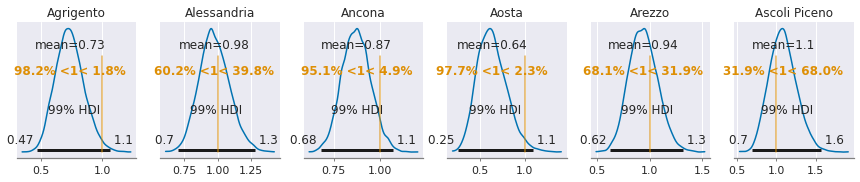

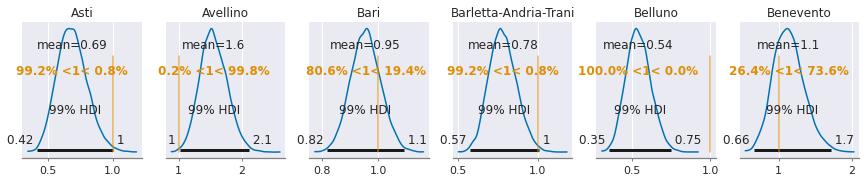

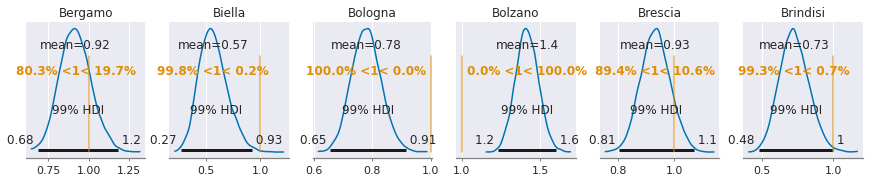

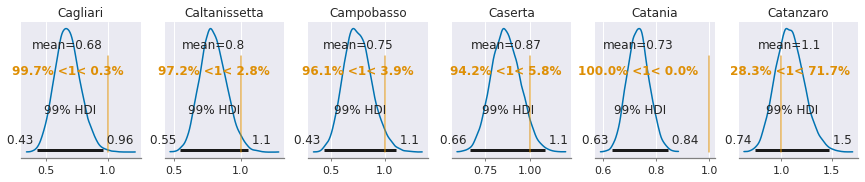

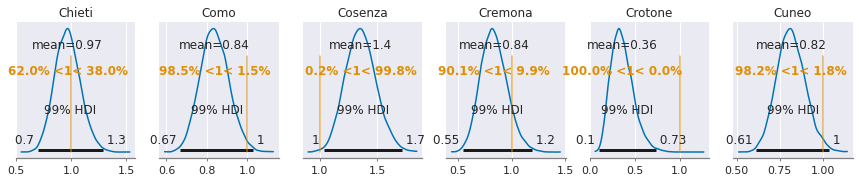

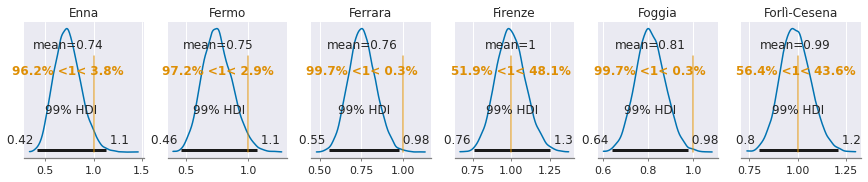

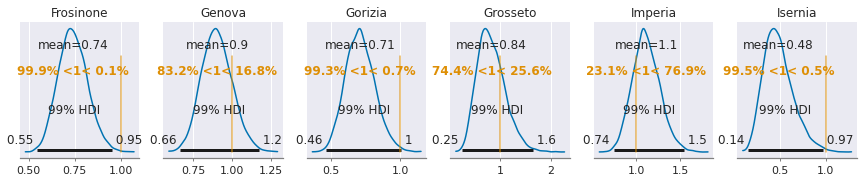

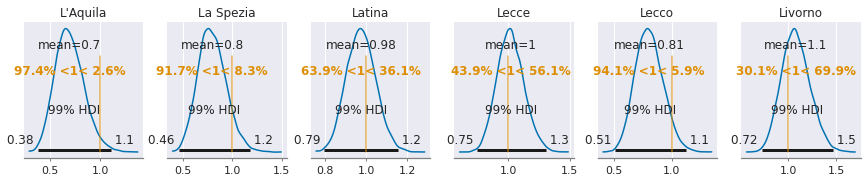

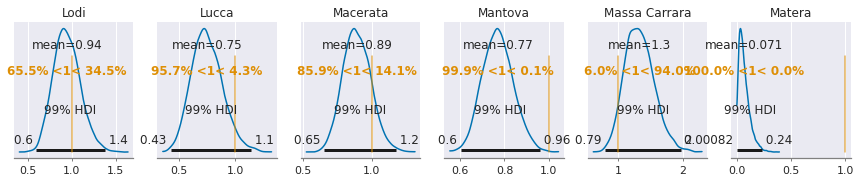

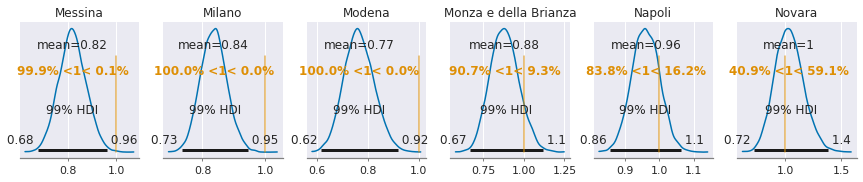

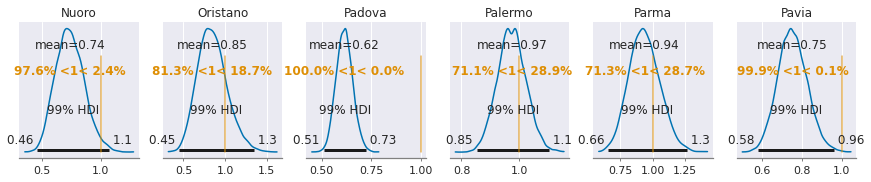

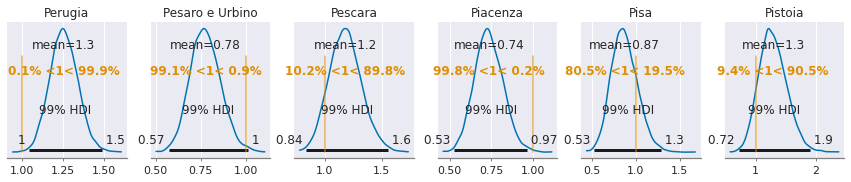

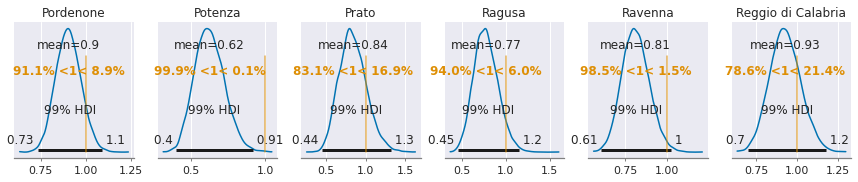

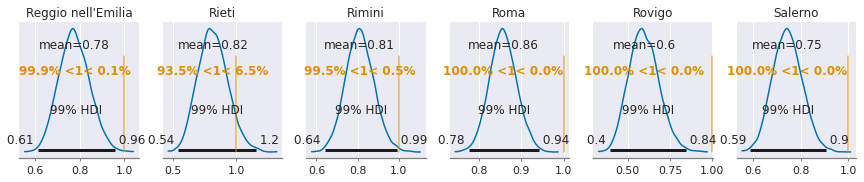

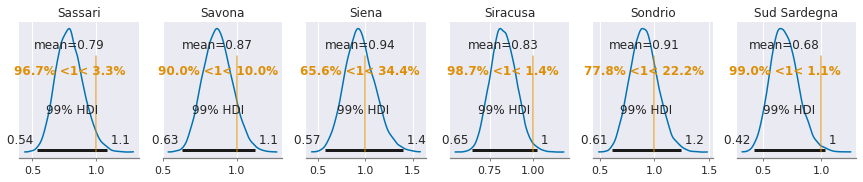

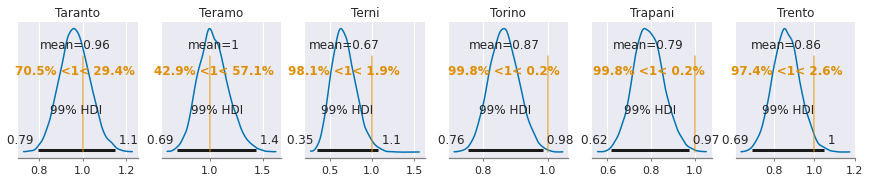

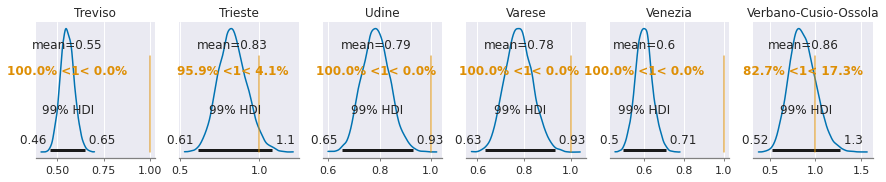

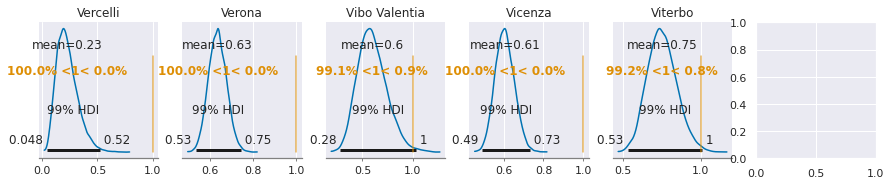

In [14]:
window = 7
ncols = 6

Rt_dict = {'provincia': [], 'mu': [], 'lo': [], 'hi': []}

for i, provincia in enumerate(sorted(pro.denominazione_provincia.unique())):

    if not i % ncols:
        fig, ax = plt.subplots(1, ncols, figsize=(15, 2.5))
    
    _df = pro[pro.denominazione_provincia==provincia]

    T = _df.index.size
    incidence = _df[['totale_casi']].diff().set_index(_df.data)[1:].copy(deep=True)
    
    incidence.loc[incidence.totale_casi<0, 'totale_casi'] = 1e-64

    #incidence.fillna(method='ffill', inplace=True)
    
    #R = epidata_Rt(
    #    incidence, 'totale_casi', SI_sh_ISS, SI_ra_ISS, title=provincia, ignore_below=50,
    #    plot=True
    #)
    
    #R, Rlo, Rhi, Rsamples = last_Rt_simulation(
    #    incidence.totale_casi.values, SI_sh_ISS, SI_ra_ISS,
    #    ci=.95,
    #)
    
    #R, Rsamples = wallinga_teunis_Rt(
    #    incidence.totale_casi,
    #    SI_sh_ISS, SI_ra_ISS,
    #    plot=False, nsim=100,
    #    title=provincia)

    #R, Rsamples = epi_estim_Rt(
    #    incidence, window=window,
    #    SI_sh=SI_sh_ISS, SI_ra=SI_ra_ISS, 
    #    title=provincia, plot_Rt=False
    #)
    
    R, Rsamples = pierini_Rt(incidence, 'totale_casi', plot=False, title=provincia,
                  SI_sh=SI_sh_ISS, SI_ra=SI_ra_ISS, plot_latest_Rt=False)
    
    if Rsamples.sum():
        az.plot_posterior(Rsamples, ref_val=1, hdi_prob=.99, ax=ax[i%ncols])
    ax[i%ncols].set_title(provincia)
    
    if not ((i+1) % ncols):
        plt.show()


    #Rt_dict['provincia'].append(provincia)
    #Rt_dict['mu'].append(R.R)
    #Rt_dict['lo'].append(R.lower)
    #Rt_dict['hi'].append(R.upper)
    
    Rt_dict['provincia'].append(provincia)
    Rt_dict['mu'].append(R['R'].iloc[-1])
    Rt_dict['lo'].append(R['lo'].iloc[-1])
    Rt_dict['hi'].append(R['hi'].iloc[-1])

In [15]:
Rt_df = pd.DataFrame(Rt_dict)

In [16]:
for p in Rt_df.provincia.unique():

    Rt_df.loc[Rt_df.provincia==p,'stato'] =\
    '>>1' if Rt_df[Rt_df.provincia==p].lo.iloc[0] > 1.5 else\
    '> 1' if Rt_df[Rt_df.provincia==p].lo.iloc[0] > 1 else\
    '< 1' if Rt_df[Rt_df.provincia==p].hi.iloc[0] < 1 else\
    '~ 1'

# Mappa

In [17]:
_ = """
fig, ax = plt.subplots(1, 2, figsize=(35, 35))

sns.pointplot(
    data=Rt_df,
    y='provincia', x='mu',
    hue='stato',
    join=False,
    hue_order=['>>1', '> 1', '~ 1', '< 1'],
    palette=['purple', 'red', 'yellow', 'limegreen'],
    ax=ax[0]
)

for provincia in Rt_df.provincia:
    _df = Rt_df[Rt_df.provincia==provincia]
    ax[0].plot(
        [_df.lo, _df.hi], [provincia, provincia],
        color='k', lw=5,
        zorder=0
    )
ax[0].axvline(1, color='k', ls='--', lw=1)
ax[0].set_title(f"Province $R_t$ {pro['data'].max().date()} ordine alfabetico (CI 99%)", fontsize=25)
ax[0].set(
    xlim=(0, np.ceil(Rt_df.hi.max())),
    ylabel=None
)


sns.pointplot(
    data=Rt_df.sort_values(by='mu'),
    y='provincia', x='mu',
    hue='stato',
    join=False,
    hue_order=['>>1', '> 1', '~ 1', '< 1'],
    palette=['purple', 'red', 'yellow', 'limegreen'],
    ax=ax[1]
)

for provincia in Rt_df.sort_values(by='mu').provincia:
    _df = Rt_df[Rt_df.provincia==provincia]
    ax[1].plot(
        [_df.lo, _df.hi], [provincia, provincia],
        color='k', lw=5,
        zorder=0
    )
ax[1].axvline(1, color='k', ls='--', lw=1)
ax[1].set_title(f"Province $R_t$ {pro['data'].max().date()} ordine media (CI 99%)", fontsize=25)
ax[1].set(
    xlim=(0, np.ceil(Rt_df.hi.max())),
    ylabel=None
)
"""

Nota metodologica:

- se l'intervallo di credibilità è inferiore a 1, $R_t$ è significativamente minore di 1 (simbolo `<1`)
- se l'intervallo di credibilità comprende 1, $R_t$ non è significativamente diverso da 1 (simbolo `~1`)
- se l'intervallo di credibilità è maggior di 1 e minore di 1.5, $R_t$ è significativamente compreso tra 1 e 1.5 (simbolo `>1`)
- se l'intervallo di credibilità è superiore a 1.5, $R_t$ è significativamente maggiore di 1.5 (simbolo `>>1`)

> NB: alcune province potrebbero essere in fase di definizione o aggiornamento, consultare il repository GitHub del Dipartimento di Protezione Civile per dettagli

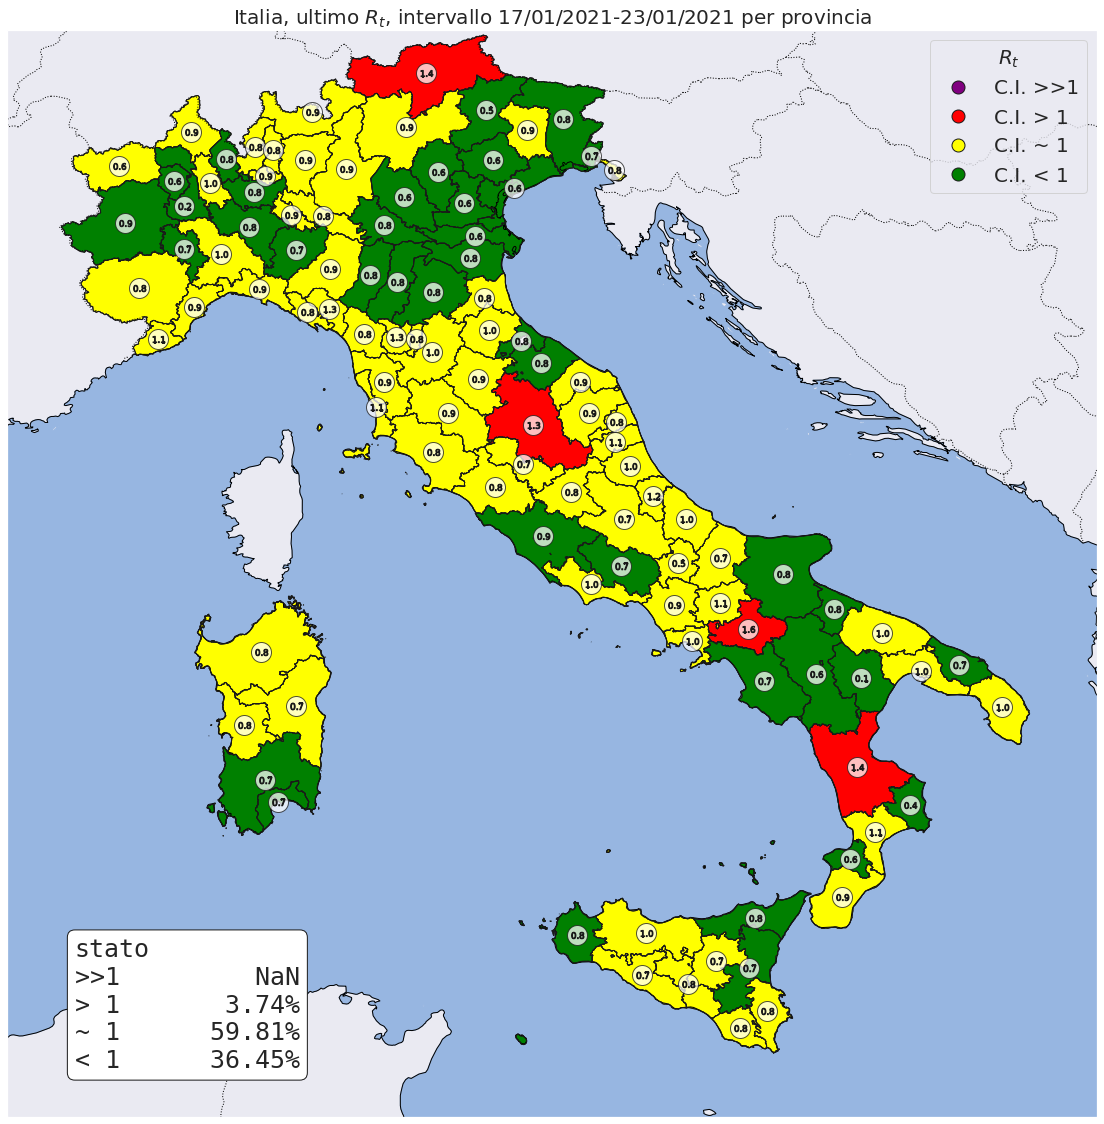

In [18]:
scatter_colors = {
    '>>1': 'purple',
    '> 1': 'red',
    '~ 1': 'yellow',
    '< 1': 'green'
}

Rt_df['color'] = Rt_df.stato.map(scatter_colors)

with open('province.geojson', 'r') as f:
    geo = json.load(f)

for feature in geo['features']:
    if feature['properties']['prov_name'] == "Valle d'Aosta/Vallée d'Aoste":
        feature['properties']['prov_name'] = 'Aosta'
    elif feature['properties']['prov_name'] == "Bolzano/Bozen":
        feature['properties']['prov_name'] = 'Bolzano'
    elif feature['properties']['prov_name'] == "Massa-Carrara":
        feature['properties']['prov_name'] = 'Massa Carrara'
    else:
        continue

def list_loop(ax, ls, col):
    try:
        poly = Polygon(ls)
        poly_patch = PolygonPatch(poly, color=col, transform=ccrs.PlateCarree(), ec='k')
        ax.add_patch(poly_patch, )
    except Exception as err:
        #print(err)
        for el in ls:
            list_loop(ax, el, col)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_extent((6, 19, 36, 47))

#ax.stock_img()
ax.coastlines()

for prov in Rt_df.provincia.unique():
    #print(prov)
    prov_name = None
    for i, feature in enumerate(geo['features']):
        if prov == feature['properties']['prov_name']:
            prov_name = feature['properties']['prov_name']
            break
    if prov_name is None:
        print(prov)
        continue

    lat = pro[pro.denominazione_provincia==prov].lat.unique()[0]
    lon = pro[pro.denominazione_provincia==prov].long.unique()[0]
    if prov == 'Messina':
        lon -= .25
    if prov == 'Prato':
        lat += .1
        lon += .1
    Rt_df.loc[Rt_df.provincia==prov, 'latitudine'] = lat
    Rt_df.loc[Rt_df.provincia==prov, 'longitudine'] = lon
    col = Rt_df[Rt_df.provincia==prov].color.unique()[0]
    
    coo = geo['features'][i]['geometry']['coordinates']
    
    list_loop(ax, coo, col)
    
    if len(coo[0]) < 10:
        poly = Polygon(coo[0][0])
    else:
        poly = Polygon(coo[0])
    
    Rt = Rt_df.loc[Rt_df.provincia==prov]['mu'].iloc[0]
    #print(lat, lon)
    
    centr = poly.centroid.coords.xy
    _lon = centr[0]
    _lat = centr[1]
    if prov == 'Vercelli':
        _lat = _lat[0] - .2
    
    ax.scatter(_lon, _lat, color='w', 
               s=400, edgecolors='k', 
               transform=ccrs.PlateCarree(), zorder=100,
               alpha=.75
              )
    
    ax.plot(
        _lon, _lat, marker=f'${Rt:.1f}$', ms=13, 
        color='k', 
        transform=ccrs.PlateCarree(),
        zorder=101,
    )
    #ax.text(
    #    lon, lat, f'${Rt:.1f}$', fontsize=8, color='w', transform=ccrs.PlateCarree(), ha='center', va='center',
    #    zorder=101
    #)

#ax.plot(-0.08, 51.53, 'o', transform=ccrs.PlateCarree())
#ax.plot([-0.08, 132], [51.53, 43.17], transform=ccrs.PlateCarree())
#ax.plot([-0.08, 132], [51.53, 43.17], transform=ccrs.Geodetic())

ax.add_feature(cfeat.BORDERS, linestyle=':')
ax.add_feature(cfeat.OCEAN)

fname = 'province-polygon.shp'
shape_feature = cfeat.ShapelyFeature(
    Reader(fname).geometries(),
    ccrs.PlateCarree(), facecolor='none', edgecolor='k')
ax.add_feature(shape_feature)
#ax.add_feature(cfeat.LAND)

stato = Rt_df.groupby('provincia')[['stato']].agg(lambda x: x.value_counts().index[0])
overview = (stato.value_counts() / Rt_df.index.size * 100).round(2).astype(str).agg(lambda x: f'{x}%').reindex(
    [
        ('>>1',),
        ('> 1',),
        ('~ 1',),
        ('< 1',)
    ]
).to_string()

ax.text(
    6.5, 36.5,
    overview,
    fontsize=25, fontfamily='monospace',
    ha='left',
    transform=ccrs.PlateCarree(),
    bbox=dict(boxstyle="round",
           ec='k',
           fc='w',
           )
)

date_min = (pro.data.iloc[-1] - pd.Timedelta(days=(window-1))).date().strftime("%d/%m/%Y")
date_max = pro.data.iloc[-1].date().strftime("%d/%m/%Y")

ax.set_title(f'Italia, ultimo $R_t$, intervallo {date_min}-{date_max} per provincia', fontsize=20)
legend_elements = [
    Line2D([0], [0], marker='o', color='k', label='C.I. >>1', markerfacecolor='purple', markersize=13, lw=0),
    Line2D([0], [0], marker='o', color='k', label='C.I. > 1', markerfacecolor='red', markersize=13, lw=0),
    Line2D([0], [0], marker='o', color='k', label='C.I. ~ 1', markerfacecolor='yellow', markersize=13, lw=0),
    Line2D([0], [0], marker='o', color='k', label='C.I. < 1', markerfacecolor='green', markersize=13, lw=0),
]
ax.legend(title="$R_t$", handles=legend_elements, loc='upper right', fontsize=20, title_fontsize=20)

#fig.tight_layout()
fig.set_facecolor('#00000000')
fig.savefig('rt-province-mappa.png', dpi=250)
plt.show()

In [19]:
end = dt.datetime.now()
time = end-start
print(f"COMPLETED IN {end-start}")
print(f"{time / Rt_df.provincia.unique().size} per province.")

COMPLETED IN 0:01:23.838483
0:00:00.783537 per province.
